# Project 4 Data Wrangling - Meng Tan

## Table of Contents
<ul>
<li><a href="#gather">Section 1 Gather</a></li>
<li><a href="#assess">Section 2 Assess</a></li>
<li><a href="#clean">Section 3 Clean</a></li>
<li><a href="#analysis">Section 4 Exploratory Data Analysis</a></li>
</ul>

In [134]:
import requests
import os
import pandas as pd
import numpy as np
import tweepy
import json
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from wordcloud import WordCloud
from PIL import Image

<a id='gather'></a>
## Section 1 Gather

In this part, we need to gather data from:
- Downloading manually
- A given url: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv
- Twitter API with Tweepy library

In [135]:
# Data from downloading manually
df_archive = pd.read_csv('data/twitter-archive-enhanced.csv')
df_archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [136]:
# Gather data with a given url
folder_name = 'data'
if not os.path.exists('data/image-predictions.tsv'):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
    response = requests.get(url)
    with open(os.path.join(folder_name, url.split('/')[-1]), mode='wb') as file:
        file.write(response.content)

In [137]:
os.listdir(folder_name)

['twitter-archive-enhanced.csv',
 '.DS_Store',
 'twitter_archive_master.pkl',
 'image-predictions.tsv',
 'tweet_json.txt']

In [138]:
df_image = pd.read_csv('data/image-predictions.tsv', '\t')
df_image.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [139]:
# Gather data with tweepy
def gather_from_tweepy(consumer_key, consumer_secret, access_token, access_secret):
    
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)

    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [140]:
if not os.path.exists('data/tweet_json.txt'):
    # Please enter your own keys:
    consumer_key = ''
    consumer_secret = ''
    access_token = ''
    access_secret = ''
    gather_from_tweepy(consumer_key, consumer_secret, access_token, access_secret)
    
    json_list = []
    tweet_deleted = []

    start = time.time()
    for tweet_id in df_archive.tweet_id:
        try:
            json_list.append(api.get_status(tweet_id, tweet_mode = 'extended')._json)
        except Exception as e:
            tweet_deleted.append(tweet_id)
    end = time.time()
    print(end - start) # Print out the processing time: 1430s
    print(len(tweet_deleted)) # 25 tweet_id information can't be extracted
    # Store the data 
    with open('data/tweet_json.txt', 'w') as file:
        json.dump(json_list, file)

In [141]:
# Read the data into a list
df_list = []
with open('data/tweet_json.txt') as file:
    json_data = json.load(file)
    for data in json_data:
        tweet_id = data['id']
        retweet_count = data['retweet_count']
        favorite_count = data['favorite_count']
        df_list.append({
            'tweet_id': tweet_id,
            'retweet_count': retweet_count,
            'favorite_count': favorite_count
        })

In [142]:
# Create Dataframe from the above list of dictionaries
df_api = pd.DataFrame(df_list)
df_api.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7352,35007
1,892177421306343426,5480,30322
2,891815181378084864,3624,22800
3,891689557279858688,7535,38277
4,891327558926688256,8120,36550


<a id='assess'></a>
## Section 2 Assess
Now we have three DataFrames: 
- From **twitter-archive-enhanced.csv**, we get `df_archive` 
- From **image-predictions.tsv**, we get `df_image`
- From **tweet_json.txt**, we get `df_api`

### `df_archive` table

In [143]:
df_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [144]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [145]:
df_archive.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [146]:
df_archive.name.value_counts()

None        745
a            55
Charlie      12
Cooper       11
Oliver       11
           ... 
Humphrey      1
Ronduh        1
Deacon        1
Rey           1
Tripp         1
Name: name, Length: 957, dtype: int64

In [147]:
# Since there are 'None' and 'a' as names shown above, maybe there are other words extracted as names
df_archive.name.str.extract('(^[a-z]+)').value_counts()

a               55
the              8
an               7
very             5
quite            4
one              4
just             4
mad              2
actually         2
not              2
getting          2
incredibly       1
all              1
this             1
by               1
his              1
such             1
infuriating      1
space            1
light            1
unacceptable     1
my               1
officially       1
old              1
life             1
dtype: int64

In [148]:
df_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [149]:
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [150]:
df_archive.rating_denominator.sort_values()

313       0
2335      2
516       7
1576     10
1575     10
       ... 
1635    110
1779    120
1634    130
902     150
1120    170
Name: rating_denominator, Length: 2356, dtype: int64

In [151]:
df_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [152]:
# Check the text for those whose denominator not equal to 10
denominator_index = df_archive[df_archive.rating_denominator != 10].index

for index in denominator_index:
    print(index, ': ', df_archive.text[index], '\n---', df_archive.rating_numerator[index], '/', df_archive.rating_denominator[index])

313 :  @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho 
--- 960 / 0
342 :  @docmisterio account started on 11/15/15 
--- 11 / 15
433 :  The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd 
--- 84 / 70
516 :  Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx 
--- 24 / 7
784 :  RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/… 
--- 9 / 11
902 :  Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE 
--- 165 / 150
1068 :  After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ 
--- 9 / 11
1120 :  Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to p

**It seems that there are two main situation when denominator not equal to 10:**
- When there are more than one dog in the picture, the rating's denominator can be greater than 10
- When there are more than one pair of digits separated by '/' and the rating is the last pair of digits (from the results, the default extraction of rating seems to be the first pair of digits)

In [153]:
df_archive.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [154]:
len(df_archive[df_archive.text.str.contains('doggo', case=False)])

107

In [155]:
df_archive.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [156]:
len(df_archive[df_archive.text.str.contains('floof', case=False)])

41

**From the above comparisons, the number of dogs for different dog stage seems not correct.**

### `df_api` table

In [157]:
df_api

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7352,35007
1,892177421306343426,5480,30322
2,891815181378084864,3624,22800
3,891689557279858688,7535,38277
4,891327558926688256,8120,36550
...,...,...,...
2326,666049248165822465,38,93
2327,666044226329800704,122,259
2328,666033412701032449,39,107
2329,666029285002620928,41,118


In [158]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   retweet_count   2331 non-null   int64
 2   favorite_count  2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


In [159]:
df_api[df_api.duplicated()]

,tweet_id,retweet_count,favorite_count


In [160]:
df_api.describe()

,tweet_id,retweet_count,favorite_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,2587.270699,7310.358644
std,6.823170e+16,4376.561690,11354.408569
min,6.660209e+17,1.000000,0.000000
25%,6.782670e+17,524.500000,1267.000000
50%,7.182469e+17,1206.000000,3171.000000
75%,7.986692e+17,2995.000000,8934.000000
max,8.924206e+17,74255.000000,150486.000000


### `df_image` table

In [161]:
df_image

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [162]:
df_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [163]:
df_image.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [164]:
df_image.query('p1_conf == 1')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
106,667866724293877760,https://pbs.twimg.com/media/CUS9PlUWwAANeAD.jpg,1,jigsaw_puzzle,1.0,False,prayer_rug,1.011300e-08,False,doormat,1.740170e-10,False


In [165]:
df_image.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [166]:
df_image.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [167]:
df_image.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
handkerchief            1
rain_barrel             1
lynx                    1
standard_schnauzer      1
terrapin                1
Name: p1, Length: 378, dtype: int64

In [168]:
df_image.p2.value_counts()

Labrador_retriever    104
golden_retriever       92
Cardigan               73
Chihuahua              44
Pomeranian             42
                     ... 
polecat                 1
medicine_chest          1
racket                  1
oxygen_mask             1
laptop                  1
Name: p2, Length: 405, dtype: int64

In [169]:
df_image.p3.value_counts()

Labrador_retriever    79
Chihuahua             58
golden_retriever      48
Eskimo_dog            38
kelpie                35
                      ..
wok                    1
mitten                 1
chickadee              1
binder                 1
rapeseed               1
Name: p3, Length: 408, dtype: int64

**From above: inconsistent word formatting for predictions including lowercase words (e.g. golden_retriever), capitalised words (e.g. Chihuahua).**

In [170]:
all_columns = pd.Series(list(df_archive) + list(df_api) + list(df_image))
all_columns

0                       tweet_id
1          in_reply_to_status_id
2            in_reply_to_user_id
3                      timestamp
4                         source
5                           text
6            retweeted_status_id
7       retweeted_status_user_id
8     retweeted_status_timestamp
9                  expanded_urls
10              rating_numerator
11            rating_denominator
12                          name
13                         doggo
14                       floofer
15                        pupper
16                         puppo
17                      tweet_id
18                 retweet_count
19                favorite_count
20                      tweet_id
21                       jpg_url
22                       img_num
23                            p1
24                       p1_conf
25                        p1_dog
26                            p2
27                       p2_conf
28                        p2_dog
29                            p3
30        

In [171]:
all_columns[all_columns.duplicated()]

17    tweet_id
20    tweet_id
dtype: object

**In the three tables, *tweet_id* is the primary key.**

### Quality
##### `df_archive` table 
- Erroneous datatypes (in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp)
- There is ' +0000' appended to timestamp and the data type of timestamp is object
- There are 78 in reply tweets and 181 retweets
- Multiple dog names are words, including 'None', 'a', 'the', etc.
- Markdown language in source column
- The datatype for source column is object not category
- There are erroneous ratings
- The number of dogs for each dog_stage (i.e. doggo, floofer, pupper, and puppo) is not correct

##### `df_api` table
- There are missing records when compared to archive (2331 vs 2356)

##### `df_image` table
- There are missing records when compared to archive (2075 vs 2356)
- Erroneous datatypes (img_num, p1, p2, p3)
- Ambiguous column names (p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog)
- Inconsistent formatting in p1, p2, p3 columns: some with capitalized first letter

### Tidiness
- One variable in four columns in `df_archive` table (dog_stage)
- There should be only one table

<a id='clean'></a>
## Section 3 Clean

In [172]:
# Make copy of three tables
df_archive_clean = df_archive.copy()
df_image_clean = df_image.copy()
df_api_clean = df_api.copy()

### Missing Data and Tidiness

-  **`df_api`: there are missing records when compared to `df_archive` (2331 vs 2356)**
-  **`df_image`: there are missing records when compared to `df_archive` (2075 vs 2356)**
- **There should be only one table**

#### Define
Join columns of `df_api` and `df_image` to `df_archive` using `join(how='inner')` method.

#### Code

In [173]:
# Inner join df_api with df_archive
df_archive_clean = df_archive_clean.join(df_api_clean.set_index('tweet_id'), on='tweet_id', how='inner')

In [174]:
# Inner join df_image with df_archive
df_archive_clean = df_archive_clean.join(df_image_clean.set_index('tweet_id'), on='tweet_id', how='inner')

#### Test

In [175]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2355
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2059 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2059 non-null   object 
 4   source                      2059 non-null   object 
 5   text                        2059 non-null   object 
 6   retweeted_status_id         72 non-null     float64
 7   retweeted_status_user_id    72 non-null     float64
 8   retweeted_status_timestamp  72 non-null     object 
 9   expanded_urls               2059 non-null   object 
 10  rating_numerator            2059 non-null   int64  
 11  rating_denominator          2059 non-null   int64  
 12  name                        2059 non-null   object 
 13  doggo                       2059 

- **One variable in four columns in `df_archive` table (dog_stage)**
- **The number of dogs for each dog_stage (i.e. doggo, floofer, pupper, and puppo) is not correct**

#### Define
Extract *doggo*, *floofer*, *pupper*, and *puppo* infomation to a *dog_stage* column using regular expressions and pandas' `str.extract` method. Drop *doggo*, *floofer*, *pupper*, and *puppo* columns when done.

#### Code

In [176]:
df_archive_clean['dog_stage'] = df_archive_clean.text.str.extract('([Dd]oggo|[Ff]loof|[Pp]upper|[Pp]uppo|DOGGO|FLOOF|PUPPER|PUPPO)', expand=False).str.lower()

In [177]:
# Replace 'floof' to 'floofer' to describe a dog correctly
df_archive_clean.dog_stage = df_archive_clean.dog_stage.replace('floof', 'floofer')

In [178]:
# Drop doggo, floofer, pupper, and puppo columns
df_archive_clean = df_archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

#### Test

In [179]:
df_archive_clean.dog_stage.value_counts()

pupper     238
doggo       78
floofer     36
puppo       29
Name: dog_stage, dtype: int64

In [180]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2355
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2059 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2059 non-null   object 
 4   source                      2059 non-null   object 
 5   text                        2059 non-null   object 
 6   retweeted_status_id         72 non-null     float64
 7   retweeted_status_user_id    72 non-null     float64
 8   retweeted_status_timestamp  72 non-null     object 
 9   expanded_urls               2059 non-null   object 
 10  rating_numerator            2059 non-null   int64  
 11  rating_denominator          2059 non-null   int64  
 12  name                        2059 non-null   object 
 13  retweet_count               2059 

*Note: dog_stage is object not categorical data type, which will be addressed in the following Quality part.*

### Quality

- **There are 78 (now is 23) in reply tweets and 181 (now is 72) retweets**
- **Erroneous datatypes (in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp)**

#### Define
Select original tweet rows (where *in_reply_to_status_id*, *in_reply_to_user_id*, *retweeted_status_id*, *retweeted_status_user_id*, *retweeted_status_timestamp* columns are null). 

Drop *in_reply_to_status_id*, *in_reply_to_user_id*, *retweeted_status_id*, *retweeted_status_user_id*, *retweeted_status_timestamp* columns when done. Since these columns being dropped, there is no need to clean their datatypes.

#### Code

In [181]:
# Select non-replying and non-retweeting rows
df_archive_clean = df_archive_clean[(df_archive_clean.in_reply_to_status_id.isnull()) & (df_archive_clean.retweeted_status_id.isnull())]

#### Test

In [182]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2355
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    1964 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   1964 non-null   object 
 4   source                      1964 non-null   object 
 5   text                        1964 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               1964 non-null   object 
 10  rating_numerator            1964 non-null   int64  
 11  rating_denominator          1964 non-null   int64  
 12  name                        1964 non-null   object 
 13  retweet_count               1964 

In [183]:
# Drop replying and retweeting related columns 
df_archive_clean = df_archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1)

In [184]:
list(df_archive_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'retweet_count',
 'favorite_count',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'dog_stage']

- **Markdown language in source column**

#### Define
Extract the content from the anchor element using regular expressions and pandas' `str.extract` method.

#### Code

In [185]:
df_archive_clean.source = df_archive_clean.source.str.extract('>([\w\s]+)<')

#### Test

In [186]:
df_archive_clean.source.value_counts()

Twitter for iPhone    1926
Twitter Web Client      28
TweetDeck               10
Name: source, dtype: int64

- **There is ' +0000' appended to timestamp and the data type of timestamp is object**
- **The datatype for source is object not category**
- **Erroneous datatypes (img_num, p1, p2, p3)** 
- **Erroneous datatype for dog_stage column (this quality problem found after creating this column in the previous cleaning steps)**

#### Define
Strip the ' +0000' using `str.strip()` method and convert *timestamp* to datetime data type using `pd.to_datetime()` method. Convert *source*, *img_num*, *p1*, *p2*, *p3*, *dog_stage* to category data type using `astype()` method.  

#### Code

In [187]:
# To datetime
df_archive_clean.timestamp = pd.to_datetime(df_archive_clean.timestamp.str.strip('\s\+0000'))

In [188]:
# To category
df_archive_clean.source = df_archive_clean.source.astype('category')
df_archive_clean.img_num = df_archive_clean.img_num.astype('category')
df_archive_clean.p1 = df_archive_clean.p1.astype('category')
df_archive_clean.p2 = df_archive_clean.p2.astype('category')
df_archive_clean.p3 = df_archive_clean.p3.astype('category')
df_archive_clean.dog_stage = df_archive_clean.dog_stage.astype('category')

#### Test

In [189]:
df_archive_clean.timestamp.sample(5)

909    2016-07-25 23:54:05
726    2016-10-02 15:10:30
1162   2016-04-23 01:41:59
491    2016-12-27 17:36:16
2015   2015-12-03 00:07:09
Name: timestamp, dtype: datetime64[ns]

In [190]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2355
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1964 non-null   int64         
 1   timestamp           1964 non-null   datetime64[ns]
 2   source              1964 non-null   category      
 3   text                1964 non-null   object        
 4   expanded_urls       1964 non-null   object        
 5   rating_numerator    1964 non-null   int64         
 6   rating_denominator  1964 non-null   int64         
 7   name                1964 non-null   object        
 8   retweet_count       1964 non-null   int64         
 9   favorite_count      1964 non-null   int64         
 10  jpg_url             1964 non-null   object        
 11  img_num             1964 non-null   category      
 12  p1                  1964 non-null   category      
 13  p1_conf             1964 non-null   float64     

- **Multiple dog names are words, including 'None', 'a', 'the', etc.**

#### Define
Replace the words in *name* column to `np.nan` using `replace()` method.

#### Code

In [191]:
df_archive_clean.name = df_archive_clean.name.replace('(^[a-z]+|None)', np.nan, regex=True)

#### Test

In [192]:
df_archive_clean.name.value_counts()

Oliver      10
Charlie     10
Cooper      10
Lucy         9
Penny        9
            ..
Jennifur     1
Chesney      1
DonDon       1
Beckham      1
Tripp        1
Name: name, Length: 910, dtype: int64

- **There are erroneous ratings**

#### Define
- 1) Find out the rows which contains more than one pair of digits separated by '/' given the rating denominator not equal to 10. Extract the last pair of digits separated by '/', and update the rating numerator and denominator by spliting this pair by '/'.
- 2) Then correct numerators by considering digits with '.'(decimal point), and update numerator and denominator in the rest part of dataset.
- 3) Finally, convert the data types of *rating_numerator* and *rating_denominator* to float data type.

*Note: There are some image containing more than one dog, so there sometimes are more than one rating in each text. The default extraction of rating is the first occurence of the digits pair separated by '/'. Since the total number of >1 rating is 27 (including the situation **1)** above), there are very few of this kind of tweets. So I decide not to make the same tweet duplicated to include the second rating or calculate the average of ratings.*

#### Code

In [193]:
#Find out the rows which contains more than one pair of digits separated by '/' given the rating denominator 
#is not equal to 10. Extract the last pair of digits separated by '/', and update the rating numerator and 
#denominator by spliting this pair by '/'.

error_rating_condition = (df_archive_clean.rating_denominator != 10) & (df_archive_clean.text.str.contains('\d+/\d+\D+\d+/\d+'))

df_archive_clean.loc[error_rating_condition, 'rating_numerator'] = df_archive_clean[error_rating_condition].text.str.extract('\d+/\d+\D+(\d+)/\d+', expand=False)
df_archive_clean.loc[error_rating_condition, 'rating_denominator'] = df_archive_clean[error_rating_condition].text.str.extract('\d+/\d+\D+\d+/(\d+)', expand=False)

In [194]:
#Correct numerators by considering digits with '.'(decimal point), 
#and update numerator and denominator in the rest part of dataset.

error_rating_condition_2 = (df_archive_clean.text.str.contains('\d+\.?\d*/\d+')) & (~error_rating_condition)

df_archive_clean.loc[error_rating_condition_2, 'rating_numerator'] = df_archive_clean[error_rating_condition_2].text.str.extract('(\d+\.?\d*)/\d+', expand=False)
df_archive_clean.loc[error_rating_condition_2, 'rating_denominator'] = df_archive_clean[error_rating_condition_2].text.str.extract('\d+\.?\d*/(\d+)', expand=False)

In [195]:
# To float
df_archive_clean.rating_numerator = df_archive_clean.rating_numerator.astype(float)
df_archive_clean.rating_denominator = df_archive_clean.rating_denominator.astype(float)

#### Test

In [196]:
df_archive_clean.rating_numerator.value_counts()

12.00      444
10.00      417
11.00      393
13.00      250
9.00       150
8.00        95
7.00        51
14.00       34
6.00        32
5.00        32
3.00        19
4.00        15
2.00         9
1.00         4
60.00        1
84.00        1
99.00        1
1776.00      1
13.50        1
11.27        1
165.00       1
11.26        1
0.00         1
9.75         1
24.00        1
45.00        1
88.00        1
144.00       1
44.00        1
121.00       1
204.00       1
80.00        1
420.00       1
Name: rating_numerator, dtype: int64

In [197]:
df_archive_clean.rating_denominator.value_counts()

10.0     1952
50.0        2
80.0        2
170.0       1
150.0       1
120.0       1
110.0       1
40.0        1
90.0        1
7.0         1
70.0        1
Name: rating_denominator, dtype: int64

- **Ambiguous column names (p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog)**

#### Define
Make these ambiguous column names more appropriate using `rename()` method.

#### Code

In [198]:
df_archive_clean = df_archive_clean.rename(columns={'p1': 'top_prediction',
                                'p1_conf': 'top_confidence',
                                'p1_dog': 'top_is_dog',
                                'p2': '2nd_prediction',
                                'p2_conf': '2nd_confidence',
                                'p2_dog': '2nd_is_dog',
                                'p3': '3rd_prediction',
                                'p3_conf': '3rd_confidence',
                                'p3_dog': '3rd_is_dog'})

#### Test

In [199]:
list(df_archive_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'retweet_count',
 'favorite_count',
 'jpg_url',
 'img_num',
 'top_prediction',
 'top_confidence',
 'top_is_dog',
 '2nd_prediction',
 '2nd_confidence',
 '2nd_is_dog',
 '3rd_prediction',
 '3rd_confidence',
 '3rd_is_dog',
 'dog_stage']

- **Inconsistent formatting in *p1 (top_prediction)*, *p2 (2nd_prediction)*, *p3 (3rd_prediction)* columns: some with '_', and some with capitalized first letter**

#### Define
Replace '_' with ' ' using `replace()` method. Make all the first letter of predictions be capitalised using `str.title()` method.

#### Code

In [200]:
column_list = ['top_prediction', '2nd_prediction', '3rd_prediction']
for column in column_list:
    df_archive_clean[column] = df_archive_clean[column].str.replace('_', ' ').str.title().astype('category')

#### Test

In [201]:
df_archive_clean[column_list].sample(10)

,top_prediction,2nd_prediction,3rd_prediction
1423,Staffordshire Bullterrier,Boston Bull,American Staffordshire Terrier
1150,Standard Poodle,Cocker Spaniel,Bucket
1021,Golden Retriever,Labrador Retriever,Seat Belt
2346,Miniature Poodle,Komondor,Soft-Coated Wheaten Terrier
2043,Pug,Bull Mastiff,French Bulldog
1081,Bath Towel,Swab,American Staffordshire Terrier
1002,Kuvasz,Samoyed,Pug
1106,Golden Retriever,Chow,Labrador Retriever
1292,Staffordshire Bullterrier,American Staffordshire Terrier,Kelpie
631,Pedestal,Fountain,Brass


In [202]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2355
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1964 non-null   int64         
 1   timestamp           1964 non-null   datetime64[ns]
 2   source              1964 non-null   category      
 3   text                1964 non-null   object        
 4   expanded_urls       1964 non-null   object        
 5   rating_numerator    1964 non-null   float64       
 6   rating_denominator  1964 non-null   float64       
 7   name                1342 non-null   object        
 8   retweet_count       1964 non-null   int64         
 9   favorite_count      1964 non-null   int64         
 10  jpg_url             1964 non-null   object        
 11  img_num             1964 non-null   category      
 12  top_prediction      1964 non-null   category      
 13  top_confidence      1964 non-null   float64     

### Store cleaned data

In [203]:
# Store cleaned data to 'twitter_archive_master.pkl', since pickle can store data types unchanged
df_archive_clean.to_pickle('data/twitter_archive_master.pkl')

<a id='analysis'></a>
## Section 4 Exploratory Data Analysis
After gathering, assessing, and cleaning process, we now have cleaned data. In this section, we need to store cleaned data to file, analyse cleaned data, and visualise the analysis.

**Store data**
- I choose to store data in pickle format, which can preserve the data types cleaned in previous steps.

**Analyse and visulise**

I get familiar with this dataset from the wrangling process, now I want to find answer for:
- Which time period during a day sees a highest number of tweets?
- Which is the favorite source for WeRateDogs?
- Which dog stage gets higher ratings?
- Which breed of dog appears most often?
- Is there any relationship between rating_numerator and favorite_count?

In [204]:
# Load data to df
df = pd.read_pickle('data/twitter_archive_master.pkl')
df.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,top_prediction,top_confidence,top_is_dog,2nd_prediction,2nd_confidence,2nd_is_dog,3rd_prediction,3rd_confidence,3rd_is_dog,dog_stage
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,7352,35007,...,Orange,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False,NaN
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,5480,30322,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True,NaN


### 4.1 Which time period during a day sees a highest number of tweets?

In [205]:
# Define a function to assign 'night', 'morning', 'afternoon', and 'evening' separately to timestamp between 
# [00:00-06:00], [06:00-12:00], [12:00-18:00], and [18:00-24:00]

def assign_day_period(hour):
    if hour >= 0 and hour < 6:
        return 'night'
    elif hour >= 6 and hour < 12:
        return 'morning'
    elif hour >= 12 and hour < 18:
        return 'afternoon'
    else:
        return 'evening'

# Apply the function to the df and save the results to a new column named 'day_period'
df['day_period'] = df.timestamp.apply(lambda x: x.hour).apply(assign_day_period)

# Convert data type to category
df.day_period = df.day_period.astype('category')

In [206]:
# Check if it works well
df[['timestamp', 'day_period']]

,timestamp,day_period
0,2017-08-01 16:23:56,afternoon
1,2017-08-01 00:17:27,night
2,2017-07-31 00:18:03,night
3,2017-07-30 15:58:51,afternoon
4,2017-07-29 16:00:24,afternoon
...,...,...
2351,2015-11-16 00:24:50,night
2352,2015-11-16 00:04:52,night
2353,2015-11-15 23:21:54,evening
2354,2015-11-15 23:05:30,evening


In [207]:
df.day_period.value_counts()

night        1017
evening       499
afternoon     445
morning         3
Name: day_period, dtype: int64

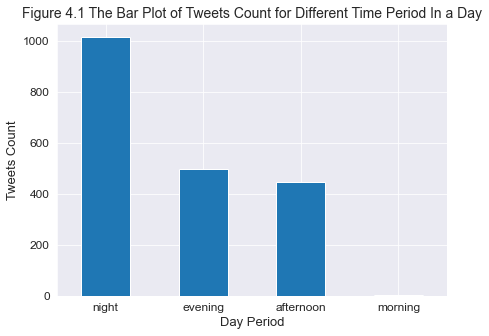

In [208]:
df.day_period.value_counts().plot(kind='bar', figsize=(7, 5), fontsize=12, rot=0)
plt.xlabel('Day Period', fontsize=13)
plt.ylabel('Tweets Count', fontsize=13)
plt.title('Figure 4.1 The Bar Plot of Tweets Count for Different Time Period In a Day', fontsize=14)
plt.savefig('1_tweet_time.png');

**From above figure, we can conclude that more than half of tweets tweeted during night, specifically from 00:00 to 06:00, and in the morning, there nearly no tweets.**

### 4.2 Which is the favorite source for WeRateDogs?

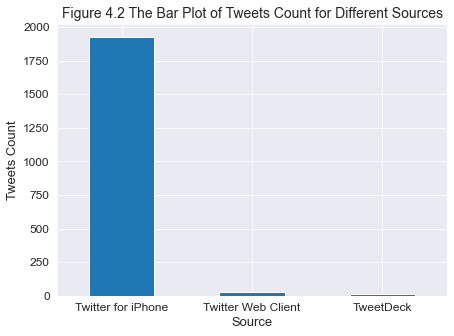

In [209]:
df.source.value_counts().plot(kind='bar', figsize=(7, 5), fontsize=12, rot=0)
plt.xlabel('Source', fontsize=13)
plt.ylabel('Tweets Count', fontsize=13)
plt.title('Figure 4.2 The Bar Plot of Tweets Count for Different Sources', fontsize=14)
plt.savefig('2_source_count.png');

**From above figure, it is clear that WeRateDogs like tweeting tweeters with Twitter for iPhone.**

### 4.3 Which dog stage gets higher ratings?

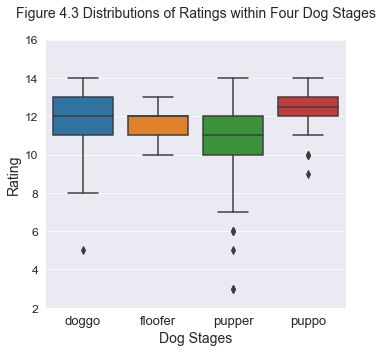

In [217]:
# Extract the dataframe with rating_denominator equals to 10
rating_data = df.query('rating_denominator == 10')

# Plot 
ax = sns.catplot(x='dog_stage', y='rating_numerator', kind='box', data=rating_data)
ax.set_xticklabels(fontsize=13)
ax.set_yticklabels(fontsize=12)
ax.set_ylabels('Rating', fontsize=14)
ax.set_xlabels('Dog Stages', fontsize=14)
plt.title('Figure 4.3 Distributions of Ratings within Four Dog Stages\n', fontsize=14)
plt.tight_layout()
plt.savefig('3_rating_stage.png');

**From the above figure, puppo seems to have higher average ratings than other three stages among all the stage-labeled dogs.**

### 4.4 Which breed of dog appears most often?

In [211]:
# I extract the dog breed data from the top_prediction column given top_is_dog is True
dog_breed = df.query('top_is_dog == True').top_prediction

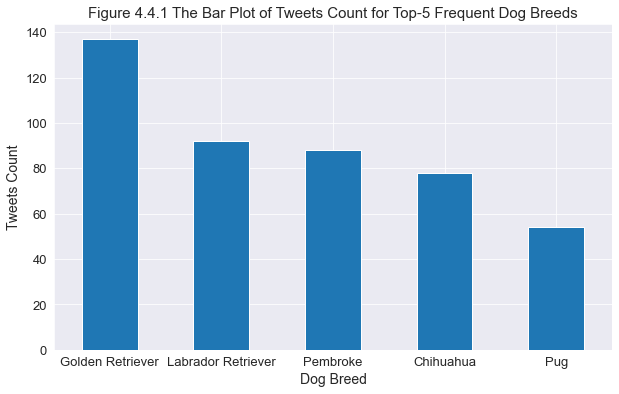

In [212]:
dog_breed.value_counts()[0:5].plot(kind='bar', figsize=(10, 6), fontsize=13, rot=0)
plt.xlabel('Dog Breed', fontsize=14)
plt.ylabel('Tweets Count', fontsize=14)
plt.title('Figure 4.4.1 The Bar Plot of Tweets Count for Top-5 Frequent Dog Breeds', fontsize=15)
plt.savefig('4_breed_count.png');

**From \#1 prediction, Golden Retriever seems to be the dog breed appears most often.**

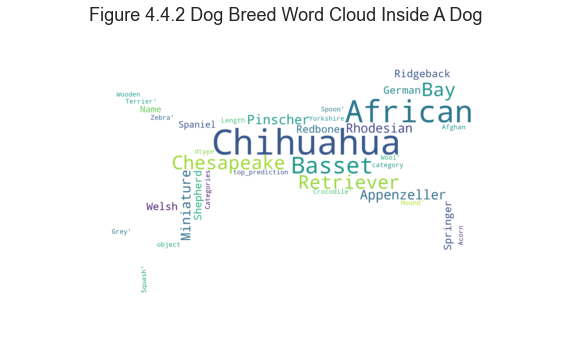

In [213]:
# Make more fashionable visualisations with wordcloud

text = str(dog_breed)

# Read the mask image
# The image source: https://www.shutterstock.com/search/running+dog+silhouette
dog_mask = np.array(Image.open('dog_silhouette.png'))

wc = WordCloud(background_color='white', mask=dog_mask,
               contour_width=1, contour_color='white')

# Generate word cloud
wc.generate(text)

# Show
plt.figure(figsize=(10, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Figure 4.4.2 Dog Breed Word Cloud Inside A Dog', fontsize=18)
plt.savefig('dog_wordcloud_white.png')
plt.show()

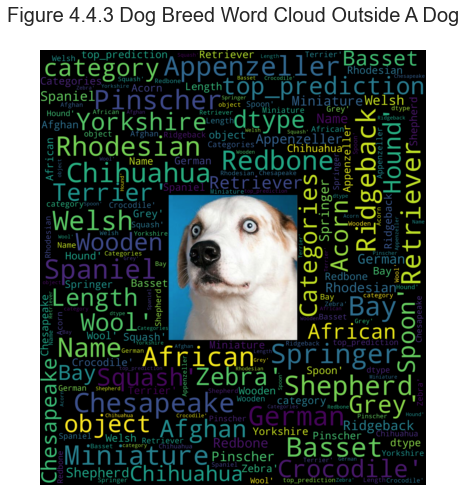

In [214]:
# Another wordcloud

# Load the dog image
# Image via Boston Magazine: https://www.bostonmagazine.com/arts-entertainment/2017/04/18/dog-rates-mit/
mask_dog = np.array(Image.open('dog.png'))[:,:,0:3]

# Create a picture in array structure, with bigger size, which surrounds 'dog.png' with black area
mask_blank = np.zeros(mask_dog.shape).astype(int)

mask_wide = np.concatenate([mask_blank, mask_dog, mask_blank], axis=0)

mask_blank_wide = np.zeros(mask_wide.shape).astype(int)

mask_whole = np.concatenate([mask_blank_wide, mask_wide, mask_blank_wide], axis=1)

# Create the mask in a photo frame shape
x, y = np.ogrid[:mask_whole.shape[0], :mask_whole.shape[1]]
mask = (x < mask_dog.shape[0]*2) & (x > mask_dog.shape[0]) & ( y < mask_dog.shape[1]*2) & (y > mask_dog.shape[1]) 
mask = 255 * mask.astype(int)

# Generate the wordcloud
wc = WordCloud(background_color='black', repeat=True, mask=mask)
wc.generate(text)

# Combine wordcloud with mask_whole
wc_whole = wc + mask_whole

# Show the wordcloud with 'dog.png'
plt.figure(figsize=(10, 8))
plt.imshow(wc_whole, interpolation='bilinear')
plt.axis('off')
plt.title('Figure 4.4.3 Dog Breed Word Cloud Outside A Dog\n', fontsize=20)
plt.savefig('dog_wordcloud_black.png')
plt.show()

### 4.5 Is there any relationship between rating_numerator and favorite_count?

In [215]:
df.rating_numerator.value_counts().iloc[0:10]

12.0    444
10.0    417
11.0    393
13.0    250
9.0     150
8.0      95
7.0      51
14.0     34
6.0      32
5.0      32
Name: rating_numerator, dtype: int64

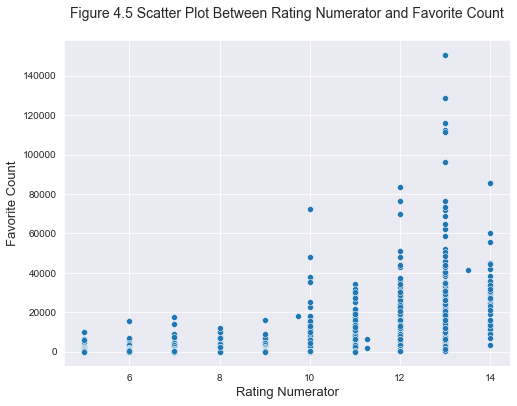

In [216]:
df_rating = df[(df['rating_numerator'] >= 5) & (df['rating_numerator'] <= 14)]

plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x='rating_numerator', y='favorite_count', data=df_rating)
ax.set_xlabel('Rating Numerator', fontsize=13)
ax.set_ylabel('Favorite Count', fontsize=13)
plt.title('Figure 4.5 Scatter Plot Between Rating Numerator and Favorite Count\n', fontsize=14)
plt.savefig('5_rating_favorite.png');

**From above figure, we can see that rating numerator 13 obtains more higher favorites, lower numerators shows less chance to get more than 20,000 favorites.**